<a href="https://colab.research.google.com/github/ArtyomHov/tensorflow-zero-to-mastery/blob/master/05__Transfer_Learning_in_TensorFlow_Part_2__Fine_tuning_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-10-09 18:00:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-09 18:00:04 (68.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")

--2024-10-09 17:56:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.0MB/s    in 8.8s    

2024-10-09 17:56:24 (18.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input

input_shape = (224, 224, 3)
base_model = EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = preprocess_input(inputs)  # Preprocess according to EfficientNetV2 requirements
x = base_model(x, training=False)  # Keep base model in inference mode
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_2D            │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1) # print out when saving a checkpoint

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 10
history_10_percent = model.fit(train_data_10_percent,
                                           epochs=initial_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="10_percent_data"),
                                                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data/20241009-185305
Epoch 1/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9586 - loss: 0.2276
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9584 - loss: 0.2286 - val_accuracy: 0.8783 - val_loss: 0.4275
Epoch 2/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9558 - loss: 0.2292
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9561 - loss: 0.2293 - val_accuracy: 0.8882 - val_loss: 0.3645
Epoch 3/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9614 - loss: 0.2153
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9616 - loss: 0.2161 - val_accuracy: 0.8799 - val_loss: 0.3651
Epoch 4/10
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accura

In [ ]:
model.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8750 - loss: 0.3871


[0.3738746643066406, 0.8812000155448914]

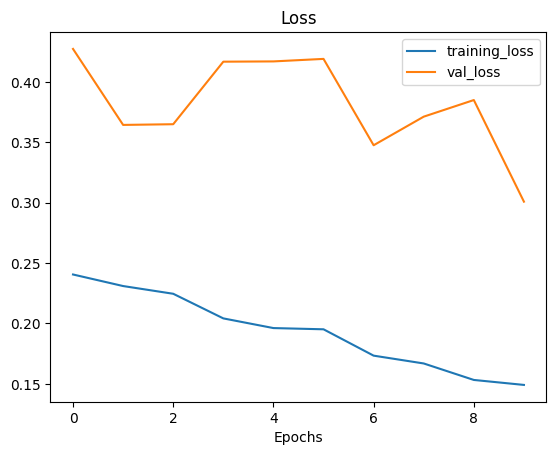

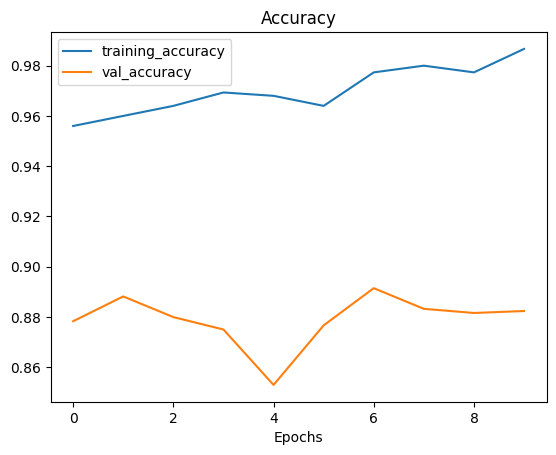

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
# Are these layers trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetv2-b0 False
global_average_pooling_2D True
output_layer True


In [ ]:
for i, layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [ ]:
print(len(model.layers[1].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model (we have to recompile our models every time we make a change)
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

In [ ]:
model.trainable_variables

[<KerasVariable shape=(1, 1, 192, 1152), dtype=float32, path=block6h_expand_conv/kernel>,
 <KerasVariable shape=(1152,), dtype=float32, path=block6h_expand_bn/gamma>,
 <KerasVariable shape=(1152,), dtype=float32, path=block6h_expand_bn/beta>,
 <KerasVariable shape=(3, 3, 1152, 1), dtype=float32, path=block6h_dwconv2/kernel>,
 <KerasVariable shape=(1152,), dtype=float32, path=block6h_bn/gamma>,
 <KerasVariable shape=(1152,), dtype=float32, path=block6h_bn/beta>,
 <KerasVariable shape=(1, 1, 1152, 48), dtype=float32, path=block6h_se_reduce/kernel>,
 <KerasVariable shape=(48,), dtype=float32, path=block6h_se_reduce/bias>,
 <KerasVariable shape=(1, 1, 48, 1152), dtype=float32, path=block6h_se_expand/kernel>,
 <KerasVariable shape=(1152,), dtype=float32, path=block6h_se_expand/bias>,
 <KerasVariable shape=(1, 1, 1152, 192), dtype=float32, path=block6h_project_conv/kernel>,
 <KerasVariable shape=(192,), dtype=float32, path=block6h_project_bn/gamma>,
 <KerasVariable shape=(192,), dtype=float3

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 10
total_epochs = initial_epochs + fine_tune_epochs

# Refir the model ( same as model except with more trainable data)
history_fine_tune = model.fit(train_data_10_percent,
                                epochs=total_epochs,
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                initial_epoch=history_10_percent.epoch[-1], # start from previous last epoch
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_fine_tune")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune/20241009-185527
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.9555 - loss: 0.2761 - val_accuracy: 0.8717 - val_loss: 0.4295
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9749 - loss: 0.2068 - val_accuracy: 0.8865 - val_loss: 0.3950
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9760 - loss: 0.1818 - val_accuracy: 0.8849 - val_loss: 0.3941
Epoch 13/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9815 - loss: 0.1697 - val_accuracy: 0.8947 - val_loss: 0.3826
Epoch 14/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.9794 - loss: 0.1401 - val_accuracy: 0.8824 - val_loss: 0.3688
Epoch 15/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9882 - loss: 0.1384 - val_accuracy: 0.8849 - val_loss: 0.3810
Epoch 16/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9954 - loss: 0.0921 - val_accuracy: 0.8914 - val_loss: 0.3556
Epoch 17/

In [ ]:
results_fine_tune_10_percent = model.evaluate(test_data)
results_fine_tune_10_percent

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.8991 - loss: 0.3319


[0.32923805713653564, 0.8999999761581421]

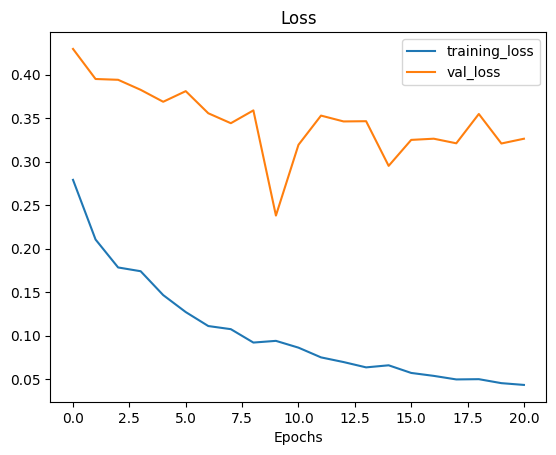

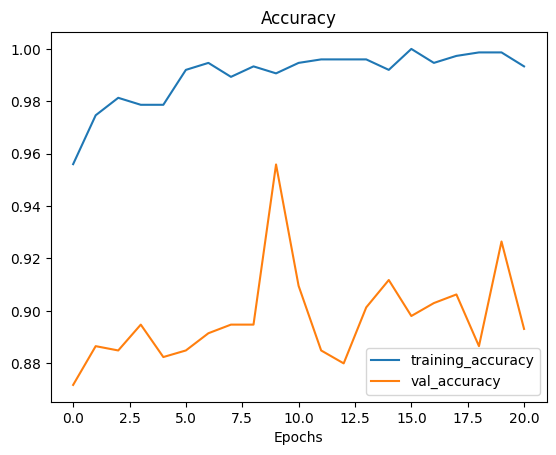

In [ ]:
# Checkout the loss curves of our fine tuned model
plot_loss_curves(history_fine_tune)

In [ ]:
# To begin fine-tuning, let's start by setting the last 30 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile the model (we have to recompile our models every time we make a change)
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 10
total_epochs = initial_epochs + fine_tune_epochs

# Refir the model ( same as model except with more trainable data)
history_fine_tune = model.fit(train_data_10_percent,
                                epochs=total_epochs,
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_fine_tune")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune/20241008-183404
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 898ms/step - accuracy: 1.0000 - loss: 0.0443 - val_accuracy: 0.8947 - val_loss: 0.3326
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9991 - loss: 0.0331 - val_accuracy: 0.9013 - val_loss: 0.2897
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9952 - loss: 0.0483 - val_accuracy: 0.8964 - val_loss: 0.3242
Epoch 13/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9991 - loss: 0.0392 - val_accuracy: 0.8898 - val_loss: 0.3257
Epoch 14/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 940ms/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 0.8971 - val_loss: 0.3046
Epoch 15/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.9982 - loss: 0.0363 - val_accuracy: 0.8931 - val_loss: 0.3343
Epoch 16/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9994 - loss: 0.0348 - val_accuracy: 0.9046 - val_loss: 0.2691
Epoch 17/

In [ ]:
results_fine_tune_10_percent = model.evaluate(test_data)
results_fine_tune_10_percent

NameError: name 'model' is not defined

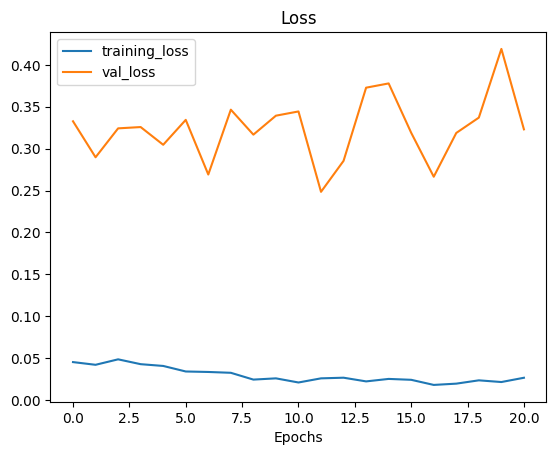

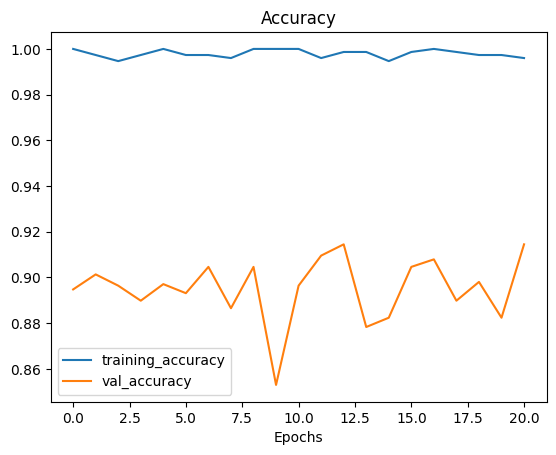

In [ ]:
# Checkout the loss curves of our fine tuned model
plot_loss_curves(history_fine_tune)

In [ ]:
class_names = train_data_10_percent.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

def visualize_image (dir, class_names, class_name):
# View a random image and compare it to its augmented version
  target_dir = dir + class_name
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + '/' + random_image

  img = image.load_img(random_image_path, target_size=(224, 224))
  img_array = image.img_to_array(img)  # Convert to numpy array of shape (224, 224, 3)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)

  # Make a prediction
  pred = model.predict(img_array)
  print(pred)

  # Get the predicted class_names
  pred_class = class_names[tf.argmax(pred[0])]

  # Read in the random image
  img = mpimg.imread(random_image_path)
  print(random_image_path)
  plt.imshow(img)
  plt.title(f"Original random image from class: {class_name} predicted as {pred_class}")
  plt.axis(False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.3619924  0.00899386 0.00160382 0.5820811  0.00296023 0.0019284
  0.00135487 0.02054466 0.00445725 0.01408347]]
10_food_classes_10_percent/test/grilled_salmon/2749008.jpg


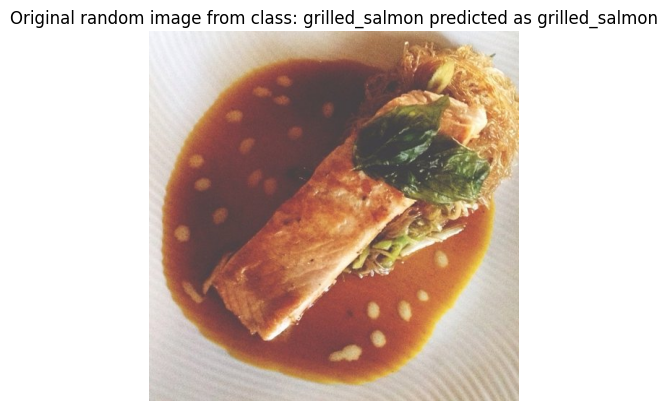

In [ ]:
visualize_image(test_dir, class_names, 'grilled_salmon')